## Description

In this notebook, we use the results of lipid quantification in Notebook 4 to segment the images.   

## Data & modules

In [1]:
%matplotlib notebook

In [2]:
from masserstein import Spectrum, estimate_proportions
from matplotlib import cm
from matplotlib import pyplot as plt
import numpy as np
from pyimzml.ImzMLParser import ImzMLParser
from pyimzml.ImzMLWriter import ImzMLWriter
from time import time
import pandas as pd
from sklearn.cluster import KMeans
from additional_functions import profile_ion_image, centroided_ion_image, segment_average_spectra

In [3]:
import numpy.random as rd

In [4]:
analyzed_mass_range = (600, 1000)

In [5]:
cerebellum_image_shape = (21, 81)
bladder_image_shape = (134, 260)

In [6]:
bladder_centroided_image = ImzMLParser('MSimages/bladder_centroided.imzML')
cerebellum_centroided_image = ImzMLParser('MSimages/cerebellum_centroided.imzML')

In [7]:
bladder_profile_image = ImzMLParser('MSimages/HR2MSI mouse urinary bladder S096.imzML')
cerebellum_profile_image = ImzMLParser('MSimages/test_POS.imzML')

/home/mciach/Py3Env/lib/python3.10/site-packages/pyimzml/ontology/ontology.py:92: UserWarning: Accession MS:1000563 found with incorrect name "Thermo RAW file". Updating name to "Thermo RAW format".
  warn(
/home/mciach/Py3Env/lib/python3.10/site-packages/pyimzml/ontology/ontology.py:92: UserWarning: Accession MS:1000590 found with incorrect name "contact organization". Updating name to "contact affiliation".
  warn(
/home/mciach/Py3Env/lib/python3.10/site-packages/pyimzml/ontology/ontology.py:92: UserWarning: Accession IMS:1000042 found with incorrect name "max count of pixel x". Updating name to "max count of pixels x".
  warn(
/home/mciach/Py3Env/lib/python3.10/site-packages/pyimzml/ontology/ontology.py:92: UserWarning: Accession IMS:1000043 found with incorrect name "max count of pixel y". Updating name to "max count of pixels y".
  warn(
/home/mciach/Py3Env/lib/python3.10/site-packages/pyimzml/ontology/ontology.py:92: UserWarning: Accession MS:1000584 found with incorrect name "mz

In [8]:
centroided_images = {'cerebellum': cerebellum_centroided_image, 
                     'bladder': bladder_centroided_image}
profile_images = {'cerebellum': cerebellum_profile_image, 
                  'bladder': bladder_profile_image}
image_shapes = {'cerebellum': cerebellum_image_shape, 
                'bladder': bladder_image_shape}
image_names = ['cerebellum', 'bladder']

Load the quantification results from Notebook 5:

In [9]:
masserstein_estimation = {n : np.load(n+'_regression_images.dmp', allow_pickle=True) for n in image_names}
[masserstein_estimation[n].shape for n in image_names]

[(21, 81, 209), (134, 260, 180)]

In [10]:
single_peak_intensities = {n : np.load(n+'_single_peak_images.dmp', allow_pickle=True) for n in image_names}
[single_peak_intensities[n].shape for n in image_names]

[(21, 81, 209), (134, 260, 180)]

In [11]:
lipid_formulas = {n : [] for n in image_names}
detection_vector = {n: [] for n in image_names}  # used to select lipids in the ion images
for i, n in enumerate(image_names):
    with open(n + '_refined_annotation_results.tsv') as h:
        next(h)  # skipping header
        for l in h:
            l = l.strip().split('\t')
            if l[-1] == 'True':  # if the lipid is detected in the image
                lipid_formulas[n].append(l[0])
            detection_vector[n].append(l[-1]=='True')
    assert len(lipid_formulas[n]) == len(set(lipid_formulas[n])), 'Formulas for %s are not unique!' % n      
    print('Loaded %i formulas for %s' % (len(lipid_formulas[n]), n))

Loaded 77 formulas for cerebellum
Loaded 44 formulas for bladder


In [12]:
single_peak_intensities = {n: single_peak_intensities[n][..., detection_vector[n]] for n in image_names}
[single_peak_intensities[n].shape for n in image_names]

[(21, 81, 77), (134, 260, 44)]

In [13]:
masserstein_estimation = {n: masserstein_estimation[n][..., detection_vector[n]] for n in image_names}
[masserstein_estimation[n].shape for n in image_names]

[(21, 81, 77), (134, 260, 44)]

In [14]:
lipid_spectra = {n: [Spectrum(f, adduct='K', threshold=0.05) for f in lipid_formulas[n]] for n in image_names}
for n in image_names:
    for s in lipid_spectra[n]:
        s.normalize()
        assert analyzed_mass_range[0] <= s.confs[0][0] <= analyzed_mass_range[1]

<IPython.core.display.Javascript object>


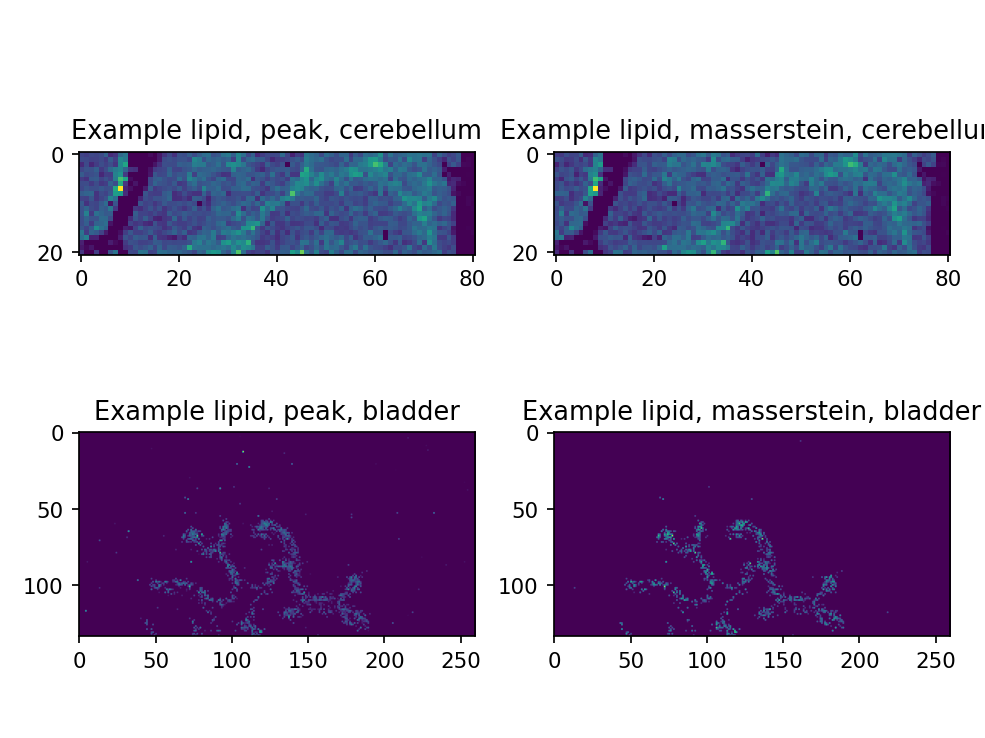

In [15]:
lipid_id = 6

plt.figure()
plt.subplot(221)
plt.title('Example lipid, peak, cerebellum')
plt.imshow(single_peak_intensities['cerebellum'][...,lipid_id])
plt.subplot(222)
plt.title('Example lipid, masserstein, cerebellum')
plt.imshow(masserstein_estimation['cerebellum'][...,lipid_id])
plt.subplot(223)
plt.title('Example lipid, peak, bladder')
plt.imshow(single_peak_intensities['bladder'][...,lipid_id])
plt.subplot(224)
plt.title('Example lipid, masserstein, bladder')
plt.imshow(masserstein_estimation['bladder'][...,lipid_id])
plt.tight_layout()

## spatial-DGMM segmentation of estimated signals  
First, load R and the Cardinal package

In [16]:
%load_ext rpy2.ipython

In [17]:
%R suppressPackageStartupMessages(library(Cardinal))

array(['Cardinal', 'S4Vectors', 'stats4', 'ProtGenerics', 'BiocGenerics',
       'BiocParallel', 'tools', 'stats', 'graphics', 'grDevices', 'utils',
       'datasets', 'methods', 'base'], dtype='<U12')

In [18]:
%R set.seed(1, kind="L'Ecuyer-CMRG")

In [19]:
%R setCardinalParallel(6)

making Snowfast cluster with 6 workers and 24 chunks


In [20]:
%%R
sessionInfo()

R version 4.4.1 (2024-06-14)
Platform: x86_64-pc-linux-gnu
Running under: Ubuntu 22.04.5 LTS

Matrix products: default
BLAS:   /usr/local/lib/R/lib/libRblas.so 
LAPACK: /usr/lib/x86_64-linux-gnu/lapack/liblapack.so.3.10.0

Random number generation:
 RNG:     L'Ecuyer-CMRG 
 Normal:  Inversion 
 Sample:  Rejection 
 
locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=pl_PL.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=pl_PL.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=pl_PL.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=pl_PL.UTF-8 LC_IDENTIFICATION=C       

time zone: Europe/Warsaw
tzcode source: system (glibc)

attached base packages:
[1] stats4    tools     stats     graphics  grDevices utils     datasets 
[8] methods   base     

other attached packages:
[1] Cardinal_3.8.0      S4Vectors_0.44.0    ProtGenerics_1.38.0
[4] BiocGenerics_0.52.0 BiocParallel_1.40.0

loaded

Convert our intensity arrays to Pandas DataFrames

In [21]:
cerebellum_df = pd.DataFrame({'L%i' % (li+1): masserstein_estimation['cerebellum'][...,li].flatten() for li in range(masserstein_estimation['cerebellum'].shape[2])})
cerebellum_df[['x', 'y']] = [(x+1,y+1) for y in range(image_shapes['cerebellum'][0]) for x in range(image_shapes['cerebellum'][1])]

bladder_df = pd.DataFrame({'L%i' % (li+1): masserstein_estimation['bladder'][...,li].flatten() for li in range(masserstein_estimation['bladder'].shape[2])})
bladder_df[['x', 'y']] = [(x+1,y+1) for y in range(image_shapes['bladder'][0]) for x in range(image_shapes['bladder'][1])]
cerebellum_df

,L1,L2,L3,L4,L5,L6,L7,L8,L9,L10,...,L70,L71,L72,L73,L74,L75,L76,L77,x,y
0,0.000411,0.004491,0.000636,0.000794,0.003634,0.008108,0.001374,0.001205,0.001264,0.013997,...,0.002281,0.012334,-0.000000,0.003357,-0.000000,0.004391,0.010896,0.012146,1,1
1,0.000608,0.004064,0.000672,0.002084,0.008717,0.007427,0.001293,0.001297,0.000993,0.014984,...,0.002841,0.008724,-0.000000,0.001606,-0.000000,0.004643,0.011131,0.011407,2,1
2,0.000972,0.004648,0.001047,0.001345,0.015493,0.006813,0.001846,0.001538,0.000814,0.010910,...,0.002657,0.011434,-0.000000,0.003360,-0.000000,0.004873,0.011616,0.008227,3,1
3,0.000503,0.004128,0.000940,0.002069,0.021567,0.011046,0.001571,0.002489,0.001949,0.010378,...,0.002958,0.009900,0.001178,0.002356,0.000970,0.003959,0.009320,0.006903,4,1
4,0.001020,0.002040,-0.000000,0.000487,0.009911,0.008148,0.001637,0.002468,0.001560,0.011115,...,0.002914,0.008386,-0.000000,0.002812,-0.000000,0.005878,0.012330,0.007706,5,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1696,0.000495,0.001926,0.000972,0.002436,0.003371,0.003830,0.001749,-0.000000,-0.000000,0.025842,...,0.002334,0.004986,0.000398,0.006832,0.000818,0.003486,0.010547,0.004874,77,21
1697,-0.000000,-0.000000,0.000000,0.000130,-0.000000,0.000000,-0.000000,0.000000,0.000000,0.001562,...,0.000090,0.000000,-0.000000,0.000000,0.001311,-0.000000,-0.000000,-0.000000,78,21
1698,-0.000000,-0.000000,0.000000,0.000000,-0.000000,0.000070,-0.000000,-0.000000,-0.000000,0.000881,...,0.000043,0.000000,0.000070,0.000000,-0.000000,-0.000000,0.000323,-0.000000,79,21
1699,-0.000000,-0.000000,0.000000,0.000125,-0.000000,0.000062,-0.000000,-0.000000,0.000000,0.001173,...,-0.000000,-0.000000,0.000005,0.000000,-0.000000,0.000069,0.000390,-0.000000,80,21


Import the data into R

In [22]:
%R -i cerebellum_df 
%R -i bladder_df

Visualize an example signal distribution throughout the cerebellum.    

In [23]:
%%R 
x <- cerebellum_df[['L4']]

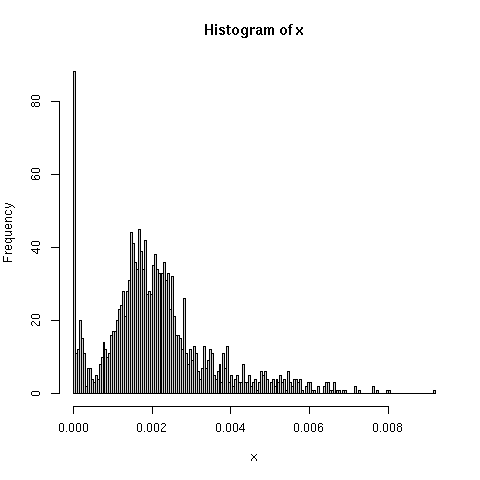

In [24]:
%%R 
hist(x, breaks=200)

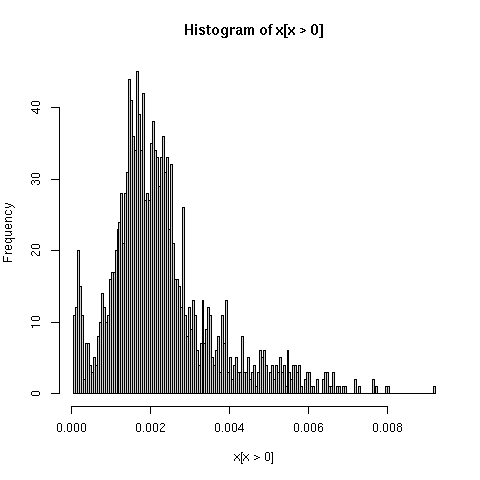

In [25]:
%%R 
hist(x[x>0], breaks=200)

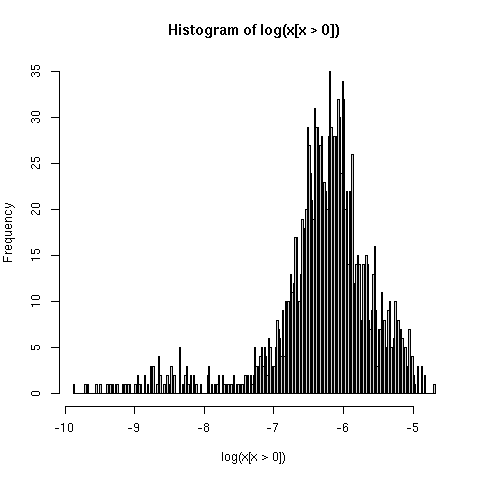

In [26]:
%%R 
hist(log(x[x>0]), breaks=200)

Creating Cardinal images. First, create imaging objects with four randomly selected lipids to find an optimal value of the `r` parameter for `spatialDGMM`.  

In [47]:
%%R 
# Creating a test image for the cerebellum
cerebellum_test_coord <- cerebellum_df[,c('x', 'y')] 
cerebellum_test_sdata <- t(unname(as.matrix(cerebellum_df[,c(20, 14, 4, 16)])))
# Optional distorition of data
# cerebellum_test_sdata <- cerebellum_test_sdata + rexp(n=ncol(cerebellum_test_sdata)*nrow(cerebellum_test_sdata), rate=1000)
cerebellum_test_run <- factor(rep("run0", nrow(cerebellum_test_coord)))
cerebellum_test_fdata <- MassDataFrame(mz=as.numeric(1:nrow(cerebellum_test_sdata)))
cerebellum_test_pdata <- PositionDataFrame(run=cerebellum_test_run, coord=cerebellum_test_coord)
# # Optional normalization
# cerebellum_test_sdata = apply(cerebellum_test_sdata, 2, function(x) x/sum(x)) 
# # Optional log-transformation
# cerebellum_test_sdata = apply(1+cerebellum_test_sdata, 2, log)
# Optional unit change
#cerebellum_test_sdata <- 100*cerebellum_test_sdata
cerebellum_test_image <- MSImagingExperiment(spectraData=cerebellum_test_sdata,
                                 featureData=cerebellum_test_fdata,
                                 pixelData=cerebellum_test_pdata,
                                 centroided = TRUE)


# Creating a test image for the bladder
bladder_test_coord <- bladder_df[,c('x', 'y')] 
bladder_test_sdata <- t(unname(as.matrix(bladder_df[,c(20, 14, 4, 16)])))
bladder_test_run <- factor(rep("run0", nrow(bladder_test_coord)))
bladder_test_fdata <- MassDataFrame(mz=as.numeric(1:nrow(bladder_test_sdata)))
bladder_test_pdata <- PositionDataFrame(run=bladder_test_run, coord=bladder_test_coord)
# # Optional normalization
# bladder_test_sdata = apply(bladder_test_sdata, 2, function(x) x/sum(x)) 
# # Optional log-transformation
# bladder_test_sdata = apply(bladder_test_sdata, 2, log)
# Optional unit change
bladder_test_sdata <- 100*bladder_test_sdata
bladder_test_image <- MSImagingExperiment(spectraData=bladder_test_sdata,
                                 featureData=bladder_test_fdata,
                                 pixelData=bladder_test_pdata,
                                 centroided = TRUE)


Test segmentation

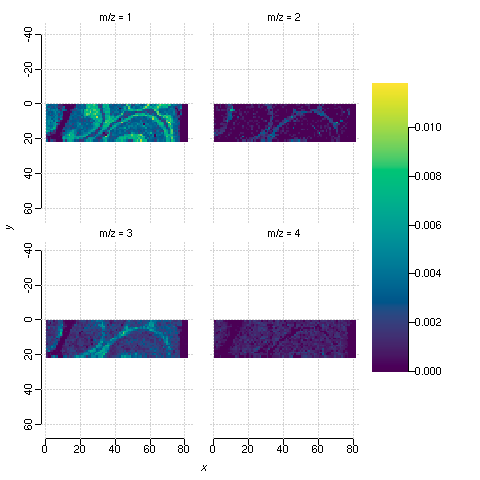

In [48]:
%%R
image(cerebellum_test_image,i=1:4)

In [51]:
%%R
cerebellum_test_sdgmm <- spatialDGMM(cerebellum_test_image, r=3, k=2)

computing gaussian weights
fitting spatial Gaussian mixture models for k = 2
fitting spatial segmentations for 4 images
# processing chunk 1/2 (2 items | 28.44 KB)
# processing chunk 2/2 (2 items | 28.44 KB)
# collecting 4 results from 2 chunks
returning spatial Gaussian mixture models
In addition: Warning message:
in sgmix(NULL, NULL, x, r = r, k = k[j], group = groups, weights = nbwts, neighbors = neighbors, byrow = byrow, annealing = annealing, compress = compress, verbose = verbose, chunkopts = chunkopts, BPPARAM = BPPARAM, ...): fewer than k classes for images 4 


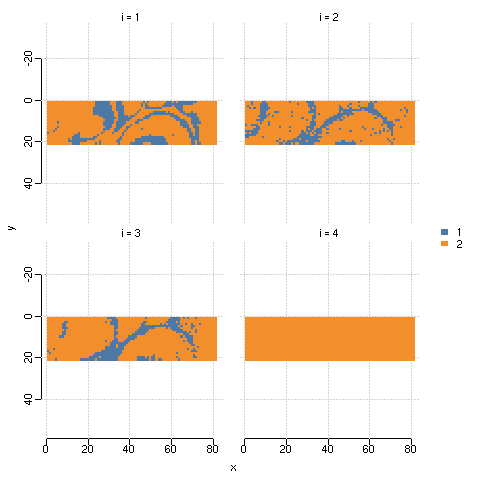

In [52]:
%%R
image(cerebellum_test_sdgmm, values='class', i=1:4)

In [55]:
%%R
bladder_test_sdgmm <- spatialDGMM(bladder_test_image, r=30, k=2)

computing gaussian weights
fitting spatial Gaussian mixture models for k = 2
fitting spatial segmentations for 4 images
# processing chunk 1/2 (2 items | 558.67 KB)
# processing chunk 2/2 (2 items | 558.67 KB)
# collecting 4 results from 2 chunks
returning spatial Gaussian mixture models


In [ ]:
%%R
image(bladder_test_sdgmm, values='class', i=1:4)

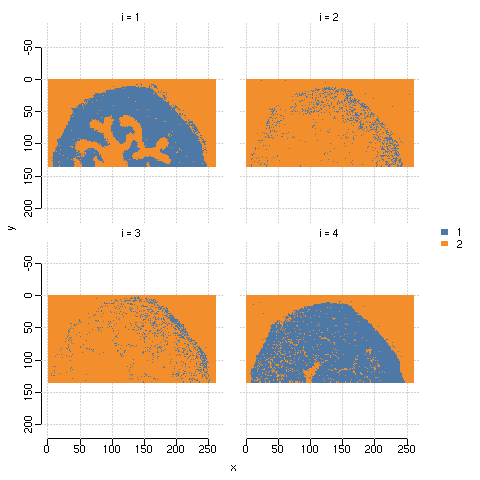

In [54]:
%%R
image(bladder_test_sdgmm, values='class', i=1:4)

Create imaging objects with the full data for segmentation

In [79]:
%%R 

# Creating cerebellum image
cerebellum_coord <- cerebellum_df[,c('x', 'y')] 
cerebellum_sdata <- t(unname(as.matrix(cerebellum_df[!names(cerebellum_df) %in% c('x', 'y')])))
cerebellum_run <- factor(rep("run0", nrow(cerebellum_coord)))
cerebellum_fdata <- MassDataFrame(mz=1:nrow(cerebellum_sdata))
cerebellum_pdata <- PositionDataFrame(run=cerebellum_run, coord=cerebellum_coord)
# # Optional normalization
# cerebellum_sdata = apply(cerebellum_sdata, 2, function(x) x/sum(x)) 
# # Optional log-transformation
# cerebellum_sdata = apply(cerebellum_sdata, 2, log)
cerebellum_image <- MSImagingExperiment(spectraData=cerebellum_sdata,
                                 featureData=cerebellum_fdata,
                                 pixelData=cerebellum_pdata,
                                 centroided = TRUE)

# Creating bladder image
bladder_coord <- bladder_df[,c('x', 'y')] 
bladder_sdata <- t(unname(as.matrix(bladder_df[!names(bladder_df) %in% c('x', 'y')])))
bladder_run <- factor(rep("run0", nrow(bladder_coord)))
bladder_fdata <- MassDataFrame(mz=as.numeric(1:nrow(bladder_sdata)))
bladder_pdata <- PositionDataFrame(run=bladder_run, coord=bladder_coord)
# # Optional normalization
# bladder_sdata = apply(bladder_sdata, 2, function(x) x/sum(x)) 
# # Optional log-transformation
# bladder_sdata = apply(bladder_sdata, 2, log)
bladder_image <- MSImagingExperiment(spectraData=bladder_sdata,
                                 featureData=bladder_fdata,
                                 pixelData=bladder_pdata,
                                 centroided = TRUE)

Segmentation

In [81]:
%%R 
bladder_sdgmm <- spatialDGMM(bladder_image, r=3, k=2)

computing gaussian weights
fitting spatial Gaussian mixture models for k = 2
fitting spatial segmentations for 44 images
# processing chunk 1/22 (2 items | 558.67 KB)
# processing chunk 2/22 (2 items | 558.67 KB)
# processing chunk 3/22 (2 items | 558.67 KB)
# processing chunk 4/22 (2 items | 558.67 KB)
# processing chunk 5/22 (2 items | 558.67 KB)
# processing chunk 6/22 (2 items | 558.67 KB)
# processing chunk 7/22 (2 items | 558.67 KB)
# processing chunk 8/22 (2 items | 558.67 KB)
# processing chunk 9/22 (2 items | 558.67 KB)
# processing chunk 10/22 (2 items | 558.67 KB)
# processing chunk 11/22 (2 items | 558.67 KB)
# processing chunk 12/22 (2 items | 558.67 KB)
# processing chunk 13/22 (2 items | 558.67 KB)
# processing chunk 14/22 (2 items | 558.67 KB)
# processing chunk 15/22 (2 items | 558.67 KB)
# processing chunk 16/22 (2 items | 558.67 KB)
# processing chunk 17/22 (2 items | 558.67 KB)
# processing chunk 18/22 (2 items | 558.67 KB)
# processing chunk 19/22 (2 items | 558.67

In [108]:
%%R
cerebellum_sdgmm <- spatialDGMM(cerebellum_image, r=3, k=2)

computing gaussian weights
fitting spatial Gaussian mixture models for k = 2
fitting spatial segmentations for 77 images
# processing chunk 1/24 (4 items | 55.67 KB)
# processing chunk 2/24 (3 items | 42.06 KB)
# processing chunk 3/24 (3 items | 42.06 KB)
# processing chunk 4/24 (3 items | 42.06 KB)
# processing chunk 5/24 (3 items | 42.06 KB)
# processing chunk 6/24 (4 items | 55.67 KB)
# processing chunk 7/24 (3 items | 42.06 KB)
# processing chunk 8/24 (3 items | 42.06 KB)
# processing chunk 9/24 (3 items | 42.06 KB)
# processing chunk 10/24 (3 items | 42.06 KB)
# processing chunk 11/24 (3 items | 42.06 KB)
# processing chunk 12/24 (4 items | 55.67 KB)
# processing chunk 13/24 (3 items | 42.06 KB)
# processing chunk 14/24 (3 items | 42.06 KB)
# processing chunk 15/24 (3 items | 42.06 KB)
# processing chunk 16/24 (3 items | 42.06 KB)
# processing chunk 17/24 (3 items | 42.06 KB)
# processing chunk 18/24 (4 items | 55.67 KB)
# processing chunk 19/24 (3 items | 42.06 KB)
# processing c

Visualize the segmentation before exporting back to Python

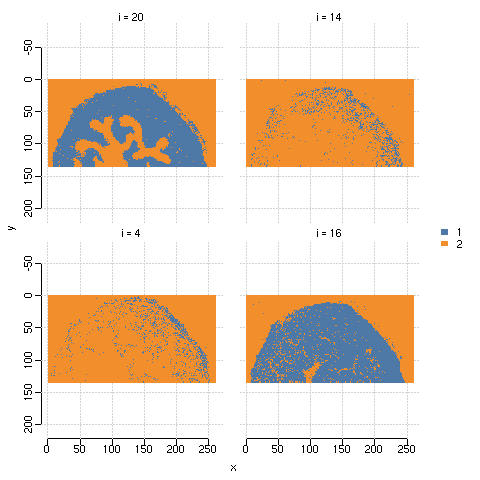

In [109]:
%%R 
image(bladder_sdgmm, values='class', i=c(20, 14, 4, 16))

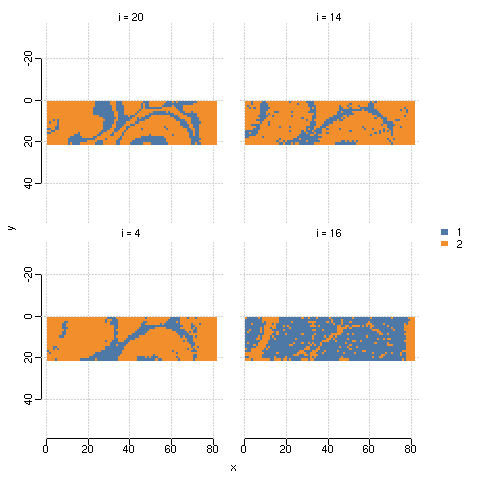

In [110]:
%%R 
image(cerebellum_sdgmm, values='class', i=c(20, 14, 4, 16))

Cast to arrays before exporting back to Python, transform class labels so that 0 = low intensity, 1 = high intensity.  

In [111]:
%%R
cerebellum_segmentation <- 2 - sapply(cerebellum_sdgmm$class, as.numeric)

bladder_segmentation <- 2 - sapply(bladder_sdgmm$class, as.numeric)
# bladder_segmentation <- cbind(bladder_coord-1, bladder_segmentation)

Export the segmentation results back to Python

In [112]:
cerebellum_sdgmm_segmentation = %Rget cerebellum_segmentation
cerebellum_sdgmm_segmentation = cerebellum_sdgmm_segmentation.reshape(image_shapes['cerebellum'] + (-1,))
bladder_sdgmm_segmentation = %Rget bladder_segmentation
bladder_sdgmm_segmentation = bladder_sdgmm_segmentation.reshape(image_shapes['bladder'] + (-1,))

masserstein_segmentation = {'cerebellum' : cerebellum_sdgmm_segmentation, 
                            'bladder' : bladder_sdgmm_segmentation}

Visualize example segmentations to verify correct exporting:

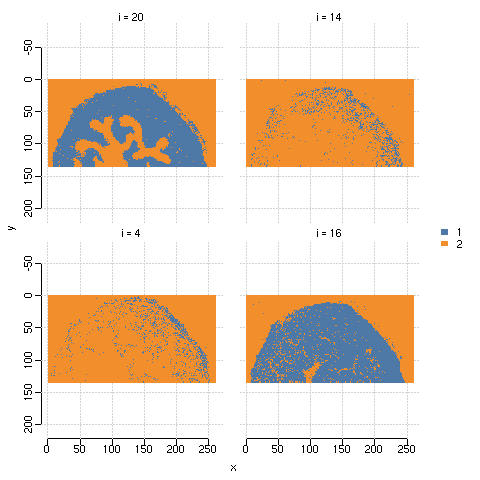

In [113]:
%%R 
image(bladder_sdgmm, values='class', i=c(20, 14, 4, 16))

<IPython.core.display.Javascript object>


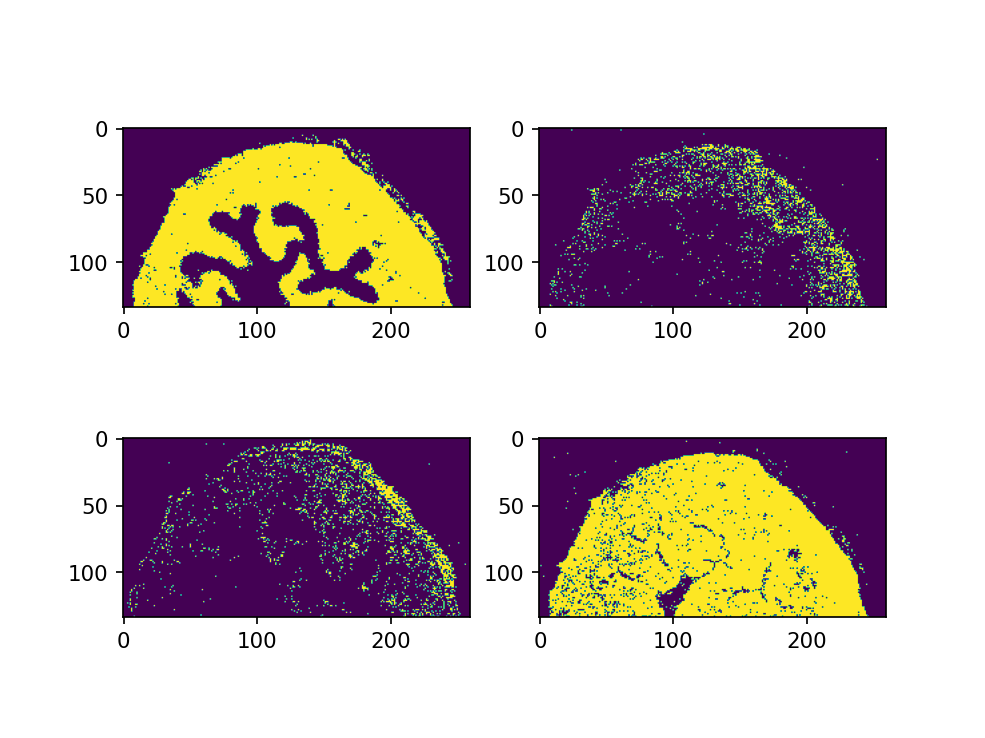

In [114]:
plt.figure()
for i, lid in enumerate((20, 14, 4, 16)):
    plt.subplot(221+i)
    plt.imshow(bladder_sdgmm_segmentation[...,lid-1])

Compare the two segmentation algorithms visually to verify correct processing (we will analyze them further in the next notebook):

<IPython.core.display.Javascript object>


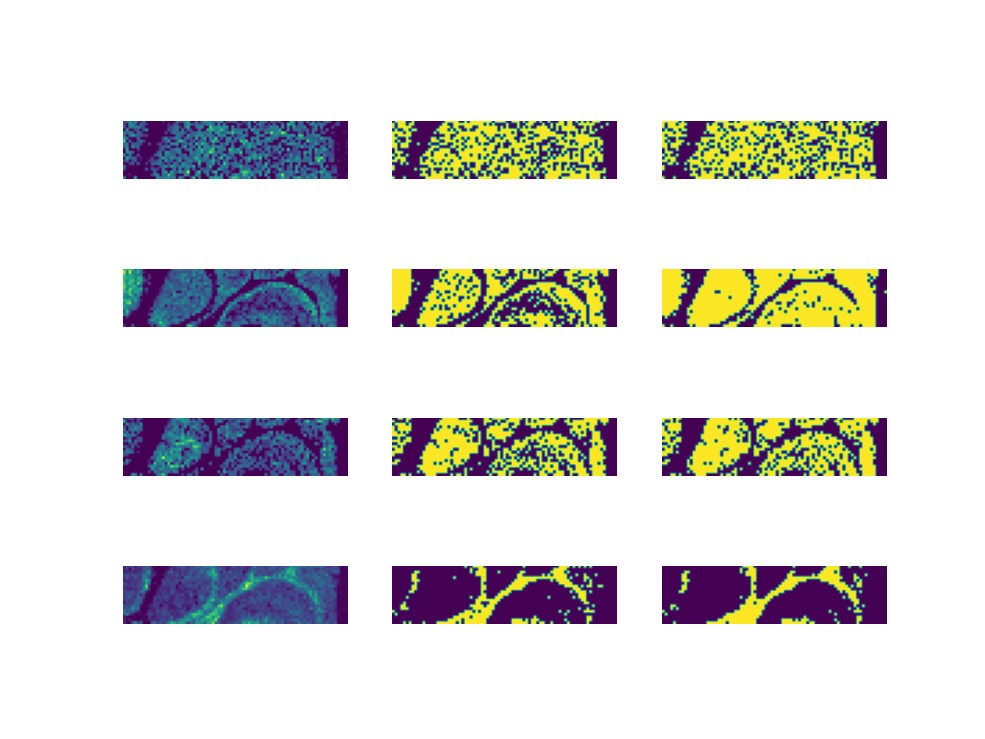

In [117]:
plt.figure()
for i in range(4):
    plt.subplot(4, 3, 1+3*i)
    plt.imshow(masserstein_estimation['cerebellum'][...,i])
    plt.axis('off')
    plt.subplot(4, 3, 2+3*i)
    plt.imshow(masserstein_kmeans_segmentation['cerebellum'][...,i])
    plt.axis('off')
    plt.subplot(4, 3, 3+3*i)
    plt.imshow(cerebellum_sdgmm_segmentation[...,i])
    plt.axis('off')

<IPython.core.display.Javascript object>


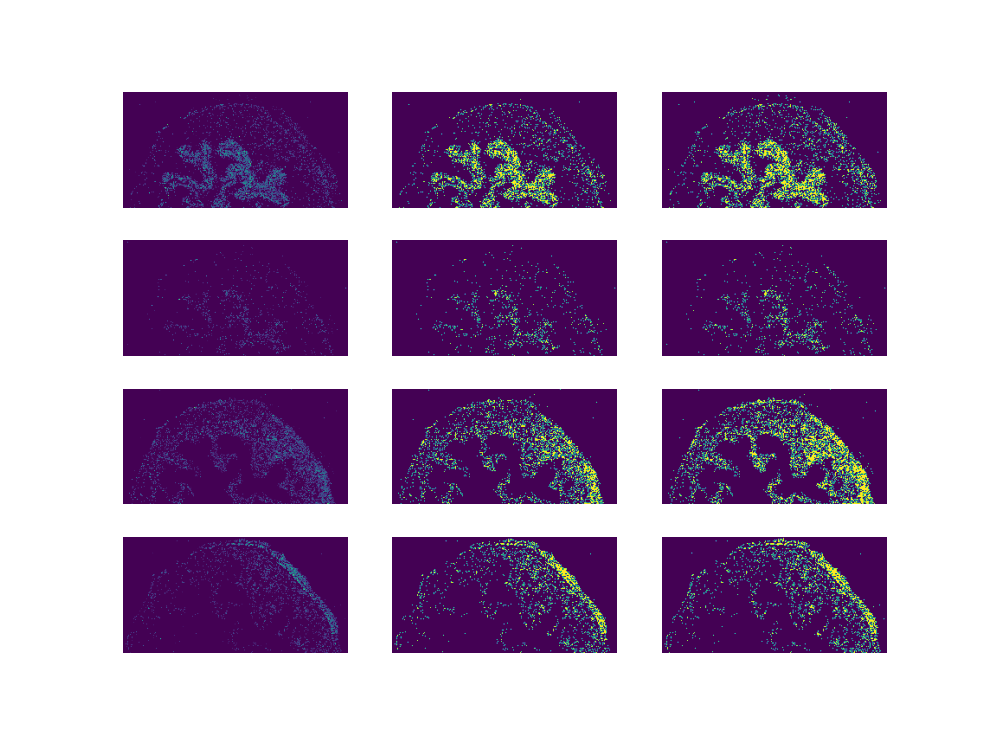

In [118]:
plt.figure()
for i in range(4):
    plt.subplot(4, 3, 1+3*i)
    plt.imshow(masserstein_estimation['bladder'][...,i])
    plt.axis('off')
    plt.subplot(4, 3, 2+3*i)
    plt.imshow(masserstein_kmeans_segmentation['bladder'][...,i])
    plt.axis('off')
    plt.subplot(4, 3, 3+3*i)
    plt.imshow(bladder_sdgmm_segmentation[...,i])
    plt.axis('off')

Save the spatial-DGMM segmentation results:

In [119]:
for n in image_names:
    masserstein_segmentation[n].dump(n+'_masserstein_sdgmm_segmentation.dmp')

In [ ]:
# # For saving as tsv:
# for n in image_names:
#     with open(n + '_sdgmm.tsv', 'w') as h:
#         sgm_table = masserstein_segmentation[n]
#         crd = masserstein_coordinates[n]
#         header = ['X', 'Y'] + list(map(str, range(sgm_table.shape[1])))
#         h.write('\t'.join(header) + '\n')
#         for l1, l2 in zip(crd, sgm_table):
#             l1 = '\t'.join(list(map(str, l1)))
#             l2 = '\t'.join(list(map(str, l2)))
#             h.write(l1 + '\t' + l2 + '\n')

## K-means segmentation of peak intensities

In [29]:
# nclust = 2
# km = KMeans(n_clusters=nclust, n_init='auto')

In [30]:
# intensity_segmentation = {n : np.zeros(single_peak_intensities[n].shape, dtype='int') for n in image_names}
# for n in image_names:
#     intsy_matrix = single_peak_intensities[n]
#     for j in range(intsy_matrix.shape[2]):
#         intsy_vector = intsy_matrix[...,j].reshape((-1,1))
#         segm = km.fit_predict(intsy_vector)
#         cluster_centers = km.cluster_centers_[:,0]
#         cluster_order = np.argsort(np.argsort(cluster_centers))
#         relabeled_segm = cluster_order[segm].reshape(intsy_matrix.shape[:2])
#         intensity_segmentation[n][...,j] = relabeled_segm
    

Visualize an example segmentation:

<IPython.core.display.Javascript object>


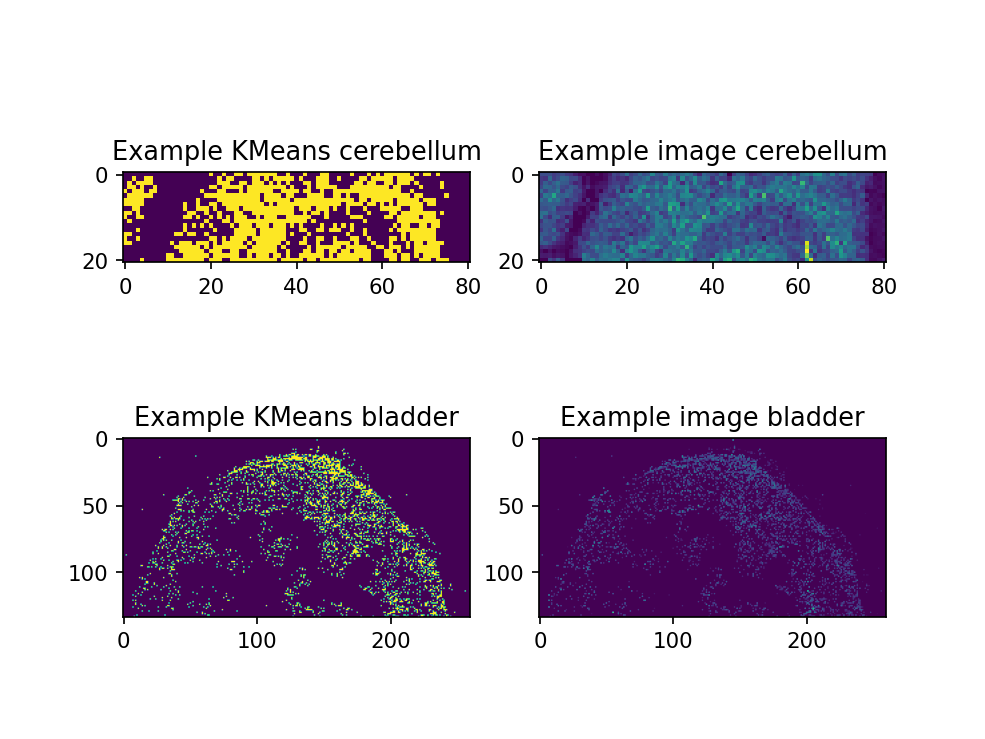

In [31]:
# lipid_id = 20

# plt.figure()
# plt.subplot(221)
# plt.title('Example KMeans cerebellum')
# plt.imshow(intensity_segmentation['cerebellum'][...,lipid_id])
# plt.subplot(222)
# plt.title('Example image cerebellum')
# plt.imshow(single_peak_intensities['cerebellum'][...,lipid_id])
# plt.subplot(223)
# plt.title('Example KMeans bladder')
# plt.imshow(intensity_segmentation['bladder'][...,lipid_id])
# plt.subplot(224)
# plt.title('Example image bladder')
# plt.imshow(single_peak_intensities['bladder'][...,lipid_id])
# plt.show()

Save the segmentation results

In [32]:
for n in image_names:
    intensity_segmentation[n].dump(n+'_peak_kmeans_segmentation.dmp')
# # For saving as tsv:
# for n in image_names:
#     with open(n + '_kmeans.tsv', 'w') as h:
#         sgm_table = intensity_segmentation[n]
#         crd = intensity_coordinates[n]
#         header = ['X', 'Y'] + list(map(str, range(sgm_table.shape[1])))
#         h.write('\t'.join(header) + '\n')
#         for l1, l2 in zip(crd, sgm_table):
#             l1 = '\t'.join(list(map(str, l1)))
#             l2 = '\t'.join(list(map(str, l2)))
#             h.write(l1 + '\t' + l2 + '\n')

## K-means segmentation of estimated signals

In [33]:
# nclust = 2
# km = KMeans(n_clusters=nclust, n_init='auto')

In [34]:
# masserstein_kmeans_segmentation = {n : np.zeros(masserstein_estimation[n].shape, dtype='int') for n in image_names}
# for n in image_names:
#     intsy_matrix = masserstein_estimation[n]
#     for j in range(intsy_matrix.shape[2]):
#         intsy_vector = intsy_matrix[...,j].reshape((-1,1))
#         segm = km.fit_predict(intsy_vector)
#         cluster_centers = km.cluster_centers_[:,0]
#         cluster_order = np.argsort(np.argsort(cluster_centers))
#         relabeled_segm = cluster_order[segm].reshape(intsy_matrix.shape[:2])
#         masserstein_kmeans_segmentation[n][...,j] = relabeled_segm

Visualize the segmentation:

<IPython.core.display.Javascript object>


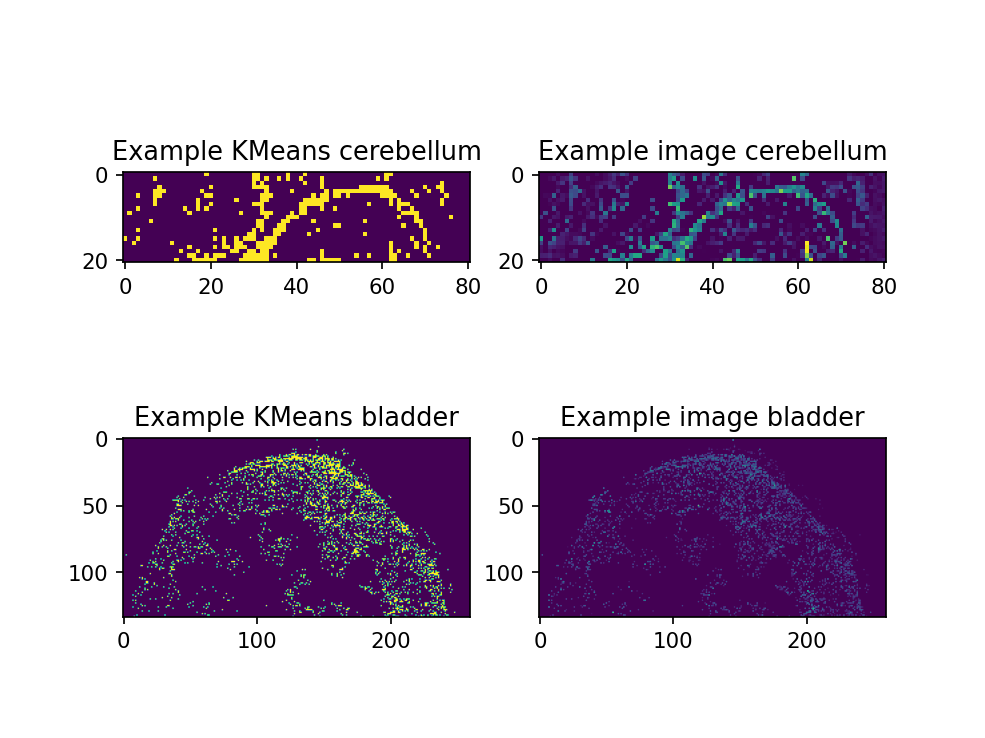

In [35]:
# lipid_id = 20

# plt.figure()
# plt.subplot(221)
# plt.title('Example KMeans cerebellum')
# plt.imshow(masserstein_kmeans_segmentation['cerebellum'][...,lipid_id])
# plt.subplot(222)
# plt.title('Example image cerebellum')
# plt.imshow(masserstein_estimation['cerebellum'][...,lipid_id])
# plt.subplot(223)
# plt.title('Example KMeans bladder')
# plt.imshow(masserstein_kmeans_segmentation['bladder'][...,lipid_id])
# plt.subplot(224)
# plt.title('Example image bladder')
# plt.imshow(masserstein_estimation['bladder'][...,lipid_id])
# plt.show()

Save the results

In [36]:
# for n in image_names:
#     masserstein_kmeans_segmentation[n].dump(n+'_masserstein_kmeans_segmentation.dmp')